# Siting Restaurants with MCLP in San Francisco

*Authors:* [Timothy Ellersiek](https://github.com/TimMcCauley), [James Gaboardi](https://github.com/jGaboardi)

This notebook implements the maximize covering location problem (MCLP) to site 2 of 10 possible locations for restaurants in San Francisco's Mission District & Bernal Heights. The objective is to maximize the demand of randomly created households able to reach the restaurants within 3 minutes afoot. 

The routing matrix is computed using [Open Source Routing Machine's demo server API](http://project-osrm.org).

## Prerequisites

To run this jupyter notebook locally, you will have to install the following additional libraries into your python environment.

- [folium](https://python-visualization.github.io/folium/)
- [routing-py](https://github.com/gis-ops/routing-py)
- [shapely](https://github.com/shapely/shapely)

In [1]:
%config InlineBackend.figure_format = "retina"
%load_ext watermark
%watermark

Last updated: 2022-12-28T21:20:27.194515-05:00

Python implementation: CPython
Python version       : 3.10.8
IPython version      : 8.7.0

Compiler    : Clang 14.0.6 
OS          : Darwin
Release     : 22.2.0
Machine     : x86_64
Processor   : i386
CPU cores   : 8
Architecture: 64bit



In [2]:
import geopandas
import folium
import json
import numpy
import pulp
import routingpy
from routingpy import OSRM
import shapely
from shapely.geometry import shape, Point
import spopt
from spopt.locate import MCLP, simulated_geo_points 

%watermark -w
%watermark -iv

Watermark: 2.3.1

shapely  : 2.0.0
pulp     : 2.7.0
folium   : 0.14.0
spopt    : 0.4.1+200.g336f235.dirty
json     : 2.0.9
geopandas: 0.12.2
routingpy: 1.1.0
numpy    : 1.23.5



-------------------------------

San Francisco's Mission District and Bernal Heights merged polygon

In [3]:
SF_MISSION_BERNAL = {
    "type": "Polygon",
    "coordinates": [
        [
            [-122.405115, 37.764635],
            [-122.405212, 37.763469],
            [-122.405832, 37.762199],
            [-122.405859, 37.761815],
            [-122.40604, 37.761865],
            [-122.406365, 37.761199],
            [-122.40645, 37.760114],
            [-122.406167, 37.759315],
            [-122.406015, 37.759409],
            [-122.405604, 37.758851],
            [-122.40405, 37.757619],
            [-122.403428, 37.756871],
            [-122.403585, 37.756818],
            [-122.403328, 37.756082],
            [-122.40315, 37.754488],
            [-122.403524, 37.754463],
            [-122.403437, 37.753199],
            [-122.403364, 37.752366],
            [-122.403022, 37.752336],
            [-122.403052, 37.752048],
            [-122.405091, 37.745281],
            [-122.405614, 37.7442],
            [-122.405493, 37.744084],
            [-122.404865, 37.744385],
            [-122.404524, 37.744285],
            [-122.406652, 37.741241],
            [-122.406936, 37.740554],
            [-122.407045, 37.739587],
            [-122.408136, 37.73964],
            [-122.408009, 37.737734],
            [-122.408218, 37.73765],
            [-122.408284, 37.736846],
            [-122.408613, 37.736074],
            [-122.409287, 37.735258],
            [-122.410052, 37.734675],
            [-122.411978, 37.733732],
            [-122.412695, 37.733197],
            [-122.414554, 37.732371],
            [-122.416255, 37.732034],
            [-122.419881, 37.732016],
            [-122.423718, 37.73155],
            [-122.425944, 37.731698],
            [-122.425256, 37.732125],
            [-122.422274, 37.732383],
            [-122.421889, 37.732533],
            [-122.421787, 37.732774],
            [-122.422472, 37.733967],
            [-122.422901, 37.734388],
            [-122.422243, 37.734846],
            [-122.422133, 37.735162],
            [-122.426983, 37.735455],
            [-122.427849, 37.734718],
            [-122.428578, 37.735082],
            [-122.42801, 37.735441],
            [-122.428454, 37.735882],
            [-122.42551, 37.737774],
            [-122.42452, 37.739868],
            [-122.42427, 37.739867],
            [-122.424394, 37.740405],
            [-122.424168, 37.740805],
            [-122.426453, 37.764634],
            [-122.421885, 37.764908],
            [-122.42173, 37.763304],
            [-122.421031, 37.76335],
            [-122.421248, 37.764947],
            [-122.407553, 37.765798],
            [-122.407431, 37.764497],
            [-122.405115, 37.764635],
        ]
    ],
}

SF_MISSION_BERNAL = str(SF_MISSION_BERNAL).replace("'", '"')
SF_MISSION_BERNAL

'{"type": "Polygon", "coordinates": [[[-122.405115, 37.764635], [-122.405212, 37.763469], [-122.405832, 37.762199], [-122.405859, 37.761815], [-122.40604, 37.761865], [-122.406365, 37.761199], [-122.40645, 37.760114], [-122.406167, 37.759315], [-122.406015, 37.759409], [-122.405604, 37.758851], [-122.40405, 37.757619], [-122.403428, 37.756871], [-122.403585, 37.756818], [-122.403328, 37.756082], [-122.40315, 37.754488], [-122.403524, 37.754463], [-122.403437, 37.753199], [-122.403364, 37.752366], [-122.403022, 37.752336], [-122.403052, 37.752048], [-122.405091, 37.745281], [-122.405614, 37.7442], [-122.405493, 37.744084], [-122.404865, 37.744385], [-122.404524, 37.744285], [-122.406652, 37.741241], [-122.406936, 37.740554], [-122.407045, 37.739587], [-122.408136, 37.73964], [-122.408009, 37.737734], [-122.408218, 37.73765], [-122.408284, 37.736846], [-122.408613, 37.736074], [-122.409287, 37.735258], [-122.410052, 37.734675], [-122.411978, 37.733732], [-122.412695, 37.733197], [-122.41

Convert `SF_MISSION_BERNAL` to a `shapely.Polygon` then a `geopandas.GeoDataFrame`

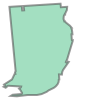

In [4]:
misson_bernal = shape(json.loads(SF_MISSION_BERNAL))
misson_bernal

In [5]:
misson_bernal = geopandas.GeoDataFrame(geometry=[misson_bernal])
misson_bernal

,geometry
0,"POLYGON ((-122.40511 37.76463, -122.40521 37.7..."


Generate 200 artificial households within `misson_bernal`

In [6]:
NUM_HOUSEHOLDS = 200
households = simulated_geo_points(misson_bernal, needed=NUM_HOUSEHOLDS, seed=0)
households = households.geometry.map(lambda pt: [pt.x, pt.y]).to_list()
households[:5]

[[-122.41455252209364, 37.75604380541952],
 [-122.41317377916111, 37.75021115925127],
 [-122.4177510779481, 37.7536705815843],
 [-122.41739502122897, 37.76209144173078],
 [-122.40834467492677, 37.74966359321169]]

## Adding a Leaflet Map for Visualisation via Folium

In the following we are using [folium](https://python-visualization.github.io/folium/) to visualize the data on the map. After creating the base map, we will load the merged polygon of Mission District and Bernal Heights boundary onto it and finally the artificial househoulds we created earlier. In the subsequent step we will add some fixed positions for our possible restaurants which are depicted as red circles.

In [7]:
m = folium.Map(
    location=[37.748273, -122.410558], tiles="cartodbpositron", zoom_start=15
)

folium.GeoJson(
    data=SF_MISSION_BERNAL,
    name="Mission District & Bernal Heights",
    style_function=lambda x: {"color": "darksalmon", "fillColor": "darksalmon"},
).add_to(m)

households_fg = folium.FeatureGroup("Households").add_to(m)
for coord in households:
    folium.CircleMarker(
        location=[coord[1], coord[0]],
        radius=3,
        fill=True,
        fill_opacity=1,
        popup=folium.Popup("Random Household", show=False),
        color="cornflowerblue",
    ).add_to(households_fg)
m

Define 10 restaurant locations

In [8]:
restaurants = [
    [-122.41957, 37.76032],
    [-122.40789, 37.75781],
    [-122.41525, 37.74622],
    [-122.42265, 37.75189],
    [-122.41890, 37.74224],
    [-122.41365, 37.73596],
    [-122.40846, 37.76454],
    [-122.41489, 37.75905],
    [-122.42365, 37.74082],
    [-122.40667, 37.74899],
]
n_rests = len(restaurants)

Add them to the map

In [9]:
restaurants_fg = folium.FeatureGroup("Restaurants").add_to(m)
for i, coord in enumerate(restaurants):
    folium.CircleMarker(
        location=[coord[1], coord[0]],
        radius=5,
        fill=True,
        fill_opacity=1,
        popup=folium.Popup(f"Potential Restaurant ({i})", show=False),
        color="crimson",
    ).add_to(restaurants_fg)
m

## Computing the Distance (Routing) Matrix

Given our 10 restaurants and 200 artificial households we want to compute our distance matrix. Instead of using simple euclidean distance we can make use of proper routes following roads which will yield more realistic travel times. The [routing-py library](https://github.com/gis-ops/routing-py) helps us achieve this which features the ability to use different open source frameworks such as OSRM or Valhalla as well as 3rd party API's such as Google Maps or HERE.

In [10]:
all_locations = households + restaurants
source_indices = [i for i in range(NUM_HOUSEHOLDS)]
target_indices = [i for i in range(NUM_HOUSEHOLDS, len(all_locations))]

In [11]:
client = OSRM(base_url="https://router.project-osrm.org")
osrm_routing_matrix = client.matrix(
    dry_run=False,
    locations=all_locations,
    sources=source_indices,
    destinations=target_indices,
    profile="pedestrian",
)
cost_matrix = numpy.array(osrm_routing_matrix.durations)

## Solving the MCLP

Last but not least we want to run the solver. We choose the `pulp.COIN_CMD` solver and set a maximium coverage to 3 minutes. Our weights of the households we set to 1 and treat them equally. Finally we loop over the solution and add the sited restaurants and the corresponding allocated households to the map with different radiuses.  

In [12]:
# maximum acceptable service duration, 3
SERVICE_RADIUS = 180

# weights, all set to 1 for demos sake
ai = numpy.ones((1, NUM_HOUSEHOLDS), dtype=int)

# the number of restaurants to site
P_FACILITIES = 2

# set the solver (for available solvers run ``pulp.listSolvers(onlyAvailable=True)``)
solver = pulp.COIN_CMD(msg=False)

In [13]:
mclp = MCLP.from_cost_matrix(cost_matrix, ai, SERVICE_RADIUS, p_facilities=P_FACILITIES)
mclp = mclp.solve(solver)

How did the model perform?

In [14]:
obj_val = int(mclp.problem.objective.value())
minutes = int(SERVICE_RADIUS/60)
obj_perc = mclp.perc_cov
print(
    f"Of the {NUM_HOUSEHOLDS} households, {obj_val} have access to at least 1 "
    f"restaurant within a {minutes}-minute walk along the street network when "
    f"siting {P_FACILITIES} restaurants. This accounts for {obj_perc}% coverage."
)

Of the 200 households, 161 have access to at least 1 restaurant within a 3-minute walk along the street network when siting 2 restaurants. This accounts for 80.5% coverage.


Add the results to the map

In [15]:
sited_restaurants_fg = folium.FeatureGroup("Sited Restaurants").add_to(m)
allocated_households_demand_fg = folium.FeatureGroup("Allocated Households").add_to(m)
solution = {}
colors = [
    "darkcyan",
    "saddlebrown",
    "lavender",
    "lightskyblue",
    "mediumseagreen",
    "coral",
    "blueviolet",
    "darkgoldenrod",
    "mediumvioletred",
    "mediumorchid"
]
for i in range(n_rests):
    if mclp.fac2cli[i]:
        folium.CircleMarker(
            location=[restaurants[i][1], restaurants[i][0]],
            radius=30,
            fill=True,
            popup=folium.Popup(f"Sited Restaurant ({i})", show=True),
            color=colors[i],
        ).add_to(sited_restaurants_fg)
        solution[i] = []
        for j in mclp.fac2cli[i]:
            solution[i].append(households[j])
            folium.CircleMarker(
                location=[households[j][1], households[j][0]],
                radius=10,
                fill=True,
                popup="Household",
                color=colors[i],
            ).add_to(allocated_households_demand_fg)
folium.LayerControl().add_to(m)
m

Inspect the solution set

In [16]:
solution

{4: [[-122.41524164428937, 37.74575134212079],
  [-122.41939041609294, 37.746517470353716],
  [-122.4232014632692, 37.735965467842085],
  [-122.42051691306378, 37.74400636648324],
  [-122.4140060513352, 37.74657122463306],
  [-122.42323994562125, 37.737074528368524],
  [-122.41188716363442, 37.74022473080378],
  [-122.4166609618889, 37.73992108767487],
  [-122.42451537332036, 37.735330127834594],
  [-122.42355414116491, 37.74417809964479],
  [-122.4213505852644, 37.735666491828425],
  [-122.42100984111212, 37.73561618691874],
  [-122.42045162186741, 37.74573767903614],
  [-122.4140979332363, 37.74063905928569],
  [-122.41520587274562, 37.73476727461245],
  [-122.42118193788865, 37.73782393776602],
  [-122.41125572058564, 37.740797233065884],
  [-122.41070210763999, 37.74173662069288],
  [-122.41170660507584, 37.74148457789174],
  [-122.41401197674212, 37.751786210327225],
  [-122.41382634618964, 37.73969735334643],
  [-122.40991900141367, 37.74223349220518],
  [-122.41840106253402, 37.